In [20]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lmfit as lm
import scipy.special as sf
from scipy.stats import norm
from scipy.stats import gaussian_kde
import pymc3 as pm
import theano.tensor as tt

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

SEED = 350107321 # from random.org
np.random.seed(SEED)

print(plt.style.available)
plt.style.use('seaborn-white')

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


In [6]:
# this is the more realistic model with periodic boundary conditions -L,L
def corrfitPB(t,N,D,w0,L):
    nmax = 5
    n = np.arange(1,nmax)
    nn,tt = np.meshgrid(n,t)
    
    efa = nn*np.pi*w0**2*1j
    an = np.exp(-nn**2*np.pi**2*w0**2/2/L**2)*(sf.erf((L**2-efa)/np.sqrt(2)/L/w0)+sf.erf((L**2+efa)/np.sqrt(2)/L/w0))
    an = np.absolute(an)**2*np.exp(-D*nn**2*np.pi**2*tt/L**2)
    return np.sum(an,axis=1)/N/2

In [7]:
dt = 0.1
D = 1.0
L = 10
#xl = 5.0
#xr = 6.0
N = 20
length = 100000

In [8]:
acf_all=None
for i in range(2000):
    # generate steps for all particles
    steps=np.random.normal(loc=0.0, scale=np.sqrt(2*D*dt), size=(N,length))
    # initial positions
    x = 2*L*np.random.random(size=(N,))
    # put initial position in front
    x = np.column_stack((x, steps))
    # calculate paths
    paths = np.mod(np.cumsum(x, axis=1),2*L)-L
    # place a Gaussian illumination at x=5.5 with unit variance
    intensity = norm.pdf(paths, loc=0)
    intensity = np.sum(intensity, axis=0)

    # calculate autocorrelation function
    f = np.fft.rfft(intensity)
    acf = np.fft.irfft(f * np.conjugate(f))
    acf = np.fft.fftshift(acf) / length
    autocorr = acf[int(length/2):]/intensity.mean()**2

    autocorr = autocorr[:1000]-1.0
    t = np.arange(0,autocorr.size)*dt
    
    if acf_all is None:
        acf_all = autocorr
    else:
        acf_all = np.vstack((acf_all, autocorr))
        
acf_std = np.std(acf_all, axis=0)
acf_mean = np.mean(acf_all, axis=0)

<ErrorbarContainer object of 3 artists>

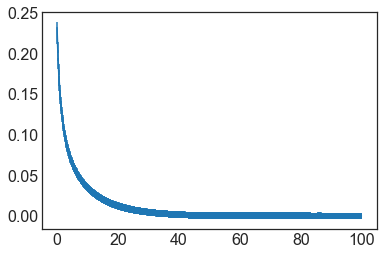

In [9]:
plt.errorbar(t,acf_mean,yerr=acf_std)

In [27]:
N_list=[]
D_list=[]
dN_list=[]
dD_list=[]

NS_list=[]
DS_list=[]
dNS_list=[]
dDS_list=[]

corrfitPB_model=lm.Model(corrfitPB)

for y in acf_all:
    paramsPB = corrfitPB_model.make_params()
    paramsPB['w0'].set(value=1,vary=False)
    paramsPB['N'].set(value=20,vary=True)
    paramsPB['D'].set(value=D,vary=True)
    paramsPB['L'].set(value=L,vary=False)

    resultPB = corrfitPB_model.fit(t=t,data=y,params=paramsPB)
    
    N_list.append(resultPB.values['N'])
    D_list.append(resultPB.values['D'])
    dN_list.append(np.sqrt(resultPB.covar[0,0]))
    dD_list.append(np.sqrt(resultPB.covar[1,1]))
                   
    paramsPBS = corrfitPB_model.make_params()
    paramsPBS['w0'].set(value=1,vary=False)
    paramsPBS['N'].set(value=20,vary=True)
    paramsPBS['D'].set(value=D,vary=True)
    paramsPBS['L'].set(value=L,vary=False)

    resultPBS = corrfitPB_model.fit(t=t,data=y,weights=1/acf_std,params=paramsPBS)
    
    NS_list.append(resultPBS.values['N'])
    DS_list.append(resultPBS.values['D'])
    dNS_list.append(np.sqrt(resultPBS.covar[0,0]))
    dDS_list.append(np.sqrt(resultPBS.covar[1,1]))


In [28]:
N_list = np.array(N_list)
dN_list = np.array(dN_list)
D_list = np.array(D_list)
dD_list = np.array(dD_list)

NS_list = np.array(NS_list)
dNS_list = np.array(dNS_list)
DS_list = np.array(DS_list)
dDS_list = np.array(dDS_list)

1.0010724956281163 0.11678649269008266
1.364206854567564 0.16737579574217296


/Users/hstrey/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


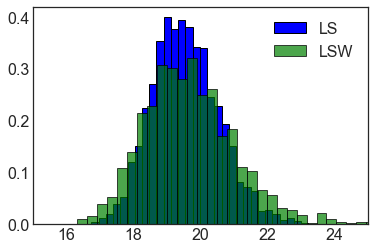

In [12]:
plt.hist(N_list,bins=30,normed=True,color="blue",edgecolor="k",label="LS")
plt.hist(NS_list,bins=30,normed=True,color="green",edgecolor="k",alpha=0.7,label="LSW")
plt.xlim((15,25))
plt.legend()
print(N_list.std(),dN_list.mean())
print(NS_list.std(),dNS_list.mean())

/Users/hstrey/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


1.0447004096358254 0.1315085396049803 0.009927965447740335
1.038974995319137 0.15261753126593353 0.011802034765279813


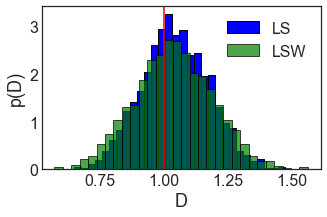

In [13]:
plt.figure(figsize=(5, 3))
plt.hist(D_list,bins=30,normed=True,color="blue",edgecolor="k",label="LS")
plt.hist(DS_list,bins=30,normed=True,color="green",edgecolor="k",label="LSW",alpha=0.7)
plt.axvline(x=1.0,color="r")
plt.xlabel("D")
plt.ylabel("p(D)")

plt.legend()
print(D_list.mean(),D_list.std(),dD_list.mean())
print(DS_list.mean(),DS_list.std(),dDS_list.mean())
#plt.savefig("FCS_D300.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

1.0447004096358254 0.1315085396049803 0.009927965447740335
1.038974995319137 0.15261753126593353 0.011802034765279813


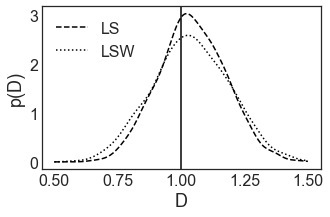

In [14]:
xd = np.linspace(0.5,1.5,200)
densityD = gaussian_kde(D_list)
densityDS = gaussian_kde(DS_list)
plt.figure(figsize=(5, 3))
plt.plot(xd,densityD(xd),"k--",label="LS")
plt.plot(xd,densityDS(xd),"k:",label="LSW")
plt.axvline(x=1.0,color="k")
plt.xlabel("D")
plt.ylabel("p(D)")

plt.legend()
print(D_list.mean(),D_list.std(),dD_list.mean())
print(DS_list.mean(),DS_list.std(),dDS_list.mean())
#plt.savefig("FCS_D300kde.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

1.2255117560623108 0.06273291556242136 0.007318508116798695
1.2330381752581028 0.08548898685261193 0.010488722552404843


/Users/hstrey/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


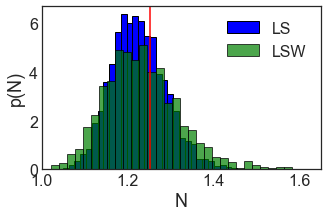

In [15]:
# instead of fitting how many particles per box N, we want to measure how many particles per focus
# size of focus is sqrt(pi/2)*w = 1.25
F_list = N_list/20.0*np.sqrt(np.pi/2)
dF_list = dN_list/20.0*np.sqrt(np.pi/2)
FS_list = NS_list/20.0*np.sqrt(np.pi/2)
dFS_list = dNS_list/20.0*np.sqrt(np.pi/2)

plt.figure(figsize=(5, 3))
plt.hist(F_list,bins=30,normed=True,color="blue",edgecolor="k",label="LS")
plt.hist(FS_list,bins=30,normed=True,color="green",edgecolor="k",alpha=0.7,label="LSW")
plt.axvline(x=np.sqrt(np.pi/2),color="r")
plt.legend()
plt.xlim((1,1.65))
plt.xlabel("N")
plt.ylabel("p(N)")
print(F_list.mean(),F_list.std(),dF_list.mean())
print(FS_list.mean(),FS_list.std(),dFS_list.mean())
#plt.savefig("FCS_N300.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

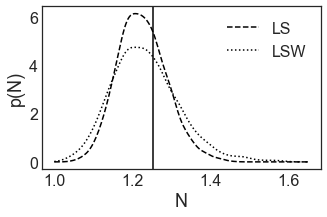

In [16]:
xn = np.linspace(1,1.65,200)
densityF = gaussian_kde(F_list)
densityFS = gaussian_kde(FS_list)
plt.figure(figsize=(5, 3))
plt.plot(xn,densityF(xn),"k--",label="LS")
plt.plot(xn,densityFS(xn),"k:",label="LSW")
plt.axvline(x=np.sqrt(np.pi/2),color="k")
plt.xlabel("N")
plt.ylabel("p(N)")

plt.legend()
#plt.savefig("FCS_N300kde.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [17]:
#find out whether the means are ok
stderr = np.sqrt(N_list.size)
print(D_list.mean(),D_list.std(),dD_list.mean(),D_list.std()/stderr)
print(DS_list.mean(),DS_list.std(),dDS_list.mean(),DS_list.std()/stderr)
print(F_list.mean(),F_list.std(),dF_list.mean(),F_list.std()/stderr)
print(FS_list.mean(),FS_list.std(),dFS_list.mean(),FS_list.std()/stderr)

1.0447004096358254 0.1315085396049803 0.009927965447740335 0.0029406203417845925
1.038974995319137 0.15261753126593353 0.011802034765279813 0.0034126317446882687
1.2255117560623108 0.06273291556242136 0.007318508116798695 0.001402750636243286
1.2330381752581028 0.08548898685261193 0.010488722552404843 0.0019115918593002605


In [37]:
N_list=[]
D_list=[]
dN_list=[]
dD_list=[]

NS_list=[]
DS_list=[]
dNS_list=[]
dDS_list=[]

w0 = 1.0
L = 10.0
nmax = 5
n = np.arange(1,nmax)
nn,tt = np.meshgrid(n,t)
    
efa = nn*np.pi*w0**2*1j
an = np.exp(-nn**2*np.pi**2*w0**2/2/L**2)*(sf.erf((L**2-efa)/np.sqrt(2)/L/w0)+sf.erf((L**2+efa)/np.sqrt(2)/L/w0))

y = acf_all[3]
with pm.Model() as model:
    NN = pm.Uniform("N",0,100)
    DD = pm.Uniform("D",0,5)
    ann = np.absolute(an)**2*np.exp(-D*nn**2*np.pi**2*tt/L**2)
    mymu = np.sum(ann,axis=1)/N/2
    likelihood = pm.Normal("likelihood",mu=mymu,tau=1,observed=y)
    trace = pm.sample(20000,burn=10000)
        


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [D, N]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:08<00:00, 9119.52draws/s] 
/Users/hstrey/anaconda3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


In [38]:
pm.summary(trace)

/Users/hstrey/anaconda3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
N,49.973585,28.75085,0.106853,1.747428,96.631152,77612.087248,0.999979
D,2.503484,1.43927,0.006384,0.248655,4.993685,72734.158243,1.000026


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f98c5b97160>,
      dtype=object)

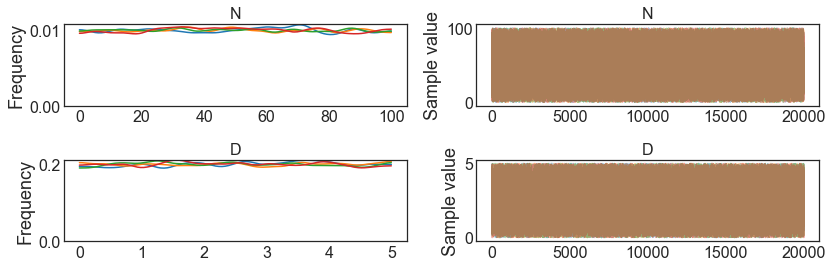

In [39]:
pm.traceplot(trace)

In [30]:
N_list[:5]

array([29.4658582 , 31.97333377, 29.06973669, 28.01845945, 26.61029407])